In [23]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
# Feature Scaling
from sklearn.preprocessing import StandardScaler
# One hot encoder
from sklearn.preprocessing import OneHotEncoder

# PCA
from sklearn.decomposition import PCA

# Grid Search
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Random Forest
from sklearn.ensemble import RandomForestClassifier
# SVM
from sklearn import svm
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
# ANN
import tensorflow as tf
from tensorflow import keras

import ml_metrics as metrics

### Read in data

In [24]:
def read_data():
    train = pd.read_csv('../train_slim.csv', sep=',')
    test = pd.read_csv('../test_slim.csv', sep=',')
    dest = pd.read_csv('../destinations.csv')
    return train, test, dest

### Feature Engineering

### Missing data

In [25]:
def missing_data(df):
    df.dropna(inplace=True)

### Convert time

In [26]:
def convert_time(df):
    df["date_time"] = pd.to_datetime(df["date_time"])
    df["srch_ci"] = pd.to_datetime(df["srch_ci"], format='%Y-%m-%d', errors="coerce")
    df["srch_co"] = pd.to_datetime(df["srch_co"], format='%Y-%m-%d', errors="coerce")
    df["stay_span"] = (df["srch_co"] - df["srch_ci"]).astype('timedelta64[h]')
    
    cols = ["month", "day", "dayofweek"]
    for col in cols:
        df["ci_{0}".format(col)] = getattr(df["srch_ci"].dt, col)
        # df["co_{0}".format(col)] = getattr(df["srch_co"].dt, col)
        
    cols = ["date_time", "srch_ci", "srch_co"]
    df.drop(cols, axis=1, inplace=True)

### Draw Correlation Matrix

In [27]:
def draw_corr(df):
    # Compute the correlation matrix
    corr = df.corr()
    
    sns.set(style="white")   
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    # Draw the heatmap and correct aspect ratio
    sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

### PCA

In [28]:
def pca(dest):
    pca = PCA(n_components=20)
    dest_pca = pca.fit_transform(dest[["d{0}".format(i + 1) for i in range(149)]])
    dest_pca = pd.DataFrame(dest_pca)
    dest_pca["srch_destination_id"] = dest["srch_destination_id"]
    
    return dest_pca

### Merge destination

In [29]:
def merge_dest(df):
    df = pd.merge(df, dest, how='left', on='srch_destination_id')
    return df

### Create distance features

In [30]:
# Apply to test set
def combine_distance(df):
    pieces = [df.groupby(['srch_destination_id','hotel_country','hotel_market','hotel_cluster'])['is_booking'].agg(['sum','count'])]
    agg = pd.concat(pieces).groupby(level=[0,1,2,3]).sum()
    agg.dropna(inplace=True)
    
    agg['sum_and_cnt'] = 0.85*agg['sum'] + 0.15*agg['count']
    agg = agg.groupby(level=[0,1,2]).apply(lambda x: x.astype(float)/x.sum())
    agg.reset_index(inplace=True)
    
    agg_pivot = agg.pivot_table(index=['srch_destination_id','hotel_country','hotel_market'], columns='hotel_cluster', values='sum_and_cnt').reset_index()
    
    df = pd.merge(df, agg_pivot, how='left', on=['srch_destination_id','hotel_country','hotel_market'])
    df.fillna(0, inplace=True)
    
    return df

### Drop non-booking events

In [31]:
def drop_non_booking(df):
    df = df.loc[df['is_booking'] == 1]
    df.drop(['is_booking'], axis=1, inplace=True)
    return df

### Drop user id

In [32]:
def drop_user_id(df):
    df.drop(['user_id'], axis=1, inplace=True)
    return df

### Feature Scaling

In [33]:
def standard_scale(a, b):
    sc = StandardScaler(copy=False)
    X_train = sc.fit_transform(a)
    X_test = sc.transform(b)
    
    return X_train, X_test

### One_hot_encode

In [34]:
def one_hot_encode(col): 
    # encode class values as integers
    encoder = OneHotEncoder()
    encoder.fit(col.reshape(-1, 1))
    col_dummy = encoder.transform(col.reshape(-1, 1)).toarray()
    return col_dummy

In [35]:
def get_top5(a):
    idx = np.argpartition(a, -5)[-5:]
    idx = idx[np.argsort(-a[idx])]
    return idx

def mapk5(y_true, y_pred):
    predictions = np.apply_along_axis(get_top5, axis=1, arr=y_pred)
    target = [[l] for l in y_true]
    acc = metrics.mapk(target, predictions, k=5)
    return acc

### Base line

In [36]:
def baseline(train, test):
    most_common_clusters = list(train.hotel_cluster.value_counts().head().index)
    predictions = [most_common_clusters for i in range(test.shape[0])]
    target = [[l] for l in test["hotel_cluster"]]
    print('MAPK5:', metrics.mapk(target, predictions, k=5))

### Naive Bayes

In [37]:
def NB_Model(X_train, y_train, X_test, y_test):
    # Set the parameters
    tuned_parameters = [{'priors': [None]}]
    
    print("# Tuning hyper-parameters for accuracy")
    print
    
    clf = GridSearchCV(GaussianNB(), tuned_parameters, cv=5, scoring='accuracy')
    clf.fit(X_train, y_train)
    
    print("Best parameters set found on development set:")
    print
    print(clf.best_params_)
    print
    print("Grid scores on development set:")
    print
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print
    
    print("Detailed classification report:")
    print
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print
    y_true, y_pred = y_test, clf.predict_proba(X_test)
    acc_mapk5 = mapk5(y_true, y_pred)
    print('MAPK5:', acc_mapk5)
    print
    
    return acc_mapk5

### SVM

In [79]:
def SVM_Model(X_train, y_train, X_test, y_test):
    # Set the parameters
    tuned_parameters = [{'decision_function_shape': ['ovo']}]

    print("# Tuning hyper-parameters for accuracy")
    print()

    clf = GridSearchCV(svm.SVC(probability=True), tuned_parameters, cv=5, scoring='accuracy')
    clf.fit(X_train, y_train)
    
    print("Best parameters set found on development set:")
    print
    print(clf.best_params_)
    print
    print("Grid scores on development set:")
    print
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print()
    
    print("Detailed classification report:")
    print
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print
    y_true, y_pred = y_test, clf.predict_proba(X_test)
    acc_mapk5 = mapk5(y_true, y_pred)
    print('MAPK5:', acc_mapk5)
    print
    
    return acc_mapk5

### Random Forest

In [39]:
def RF_Model(X_train, y_train, X_test, y_test):
    # Set the parameters
    tuned_parameters = [{'n_estimators': [100], 'max_depth': [10]}]
    
    
    print("# Tuning hyper-parameters for accuracy")
    print
    
    clf = GridSearchCV(RandomForestClassifier(random_state=0), tuned_parameters, cv=5, scoring='accuracy')
    clf.fit(X_train, y_train)
    
    print("Best parameters set found on development set:")
    print
    print(clf.best_params_)
    print
    print("Grid scores on development set:")
    print
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print
    
    print("Detailed classification report:")
    print
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print
    y_true, y_pred = y_test, clf.predict_proba(X_test)
    acc_mapk5 = mapk5(y_true, y_pred)
    print('MAPK5:', acc_mapk5)
    print
        
    return acc_mapk5

### ANN

In [54]:
def ANN_Model(X_train, y_train, X_test, y_test, y_train_dummy, y_test_dummy):
    model = keras.models.Sequential([
        keras.layers.Dense(75, activation=tf.nn.relu),
        keras.layers.Dense(75, activation=tf.nn.relu),
        keras.layers.Dense(75, activation=tf.nn.relu),
        keras.layers.Dense(100, activation=tf.nn.softmax)
    ])
    
    model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    
    model.fit(X_train, y_train_dummy, epochs=50, batch_size=10)
    
    test_loss, test_acc = model.evaluate(X_test, y_test_dummy)
    print('Test accuracy:', test_acc)
    
    y_true, y_pred = y_test, model.predict(X_test)
    acc_mapk5 = mapk5(y_true, y_pred)
    print('MAPK5:', acc_mapk5)
    print
    
    return acc_mapk5

### Baseline

In [41]:
# read data
train, test, dest = read_data()
baseline(train, test)

('MAPK5:', 0.062291108559765274)


### Correlation Matrix

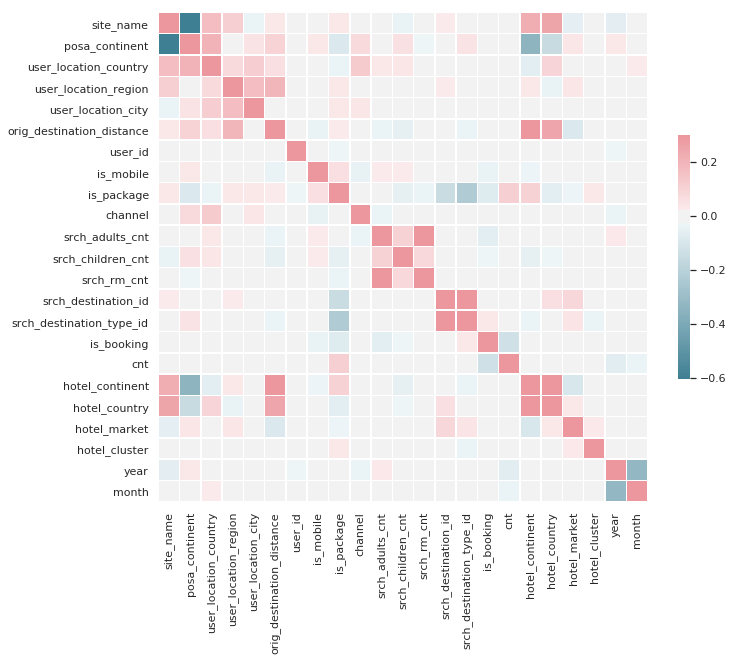

In [42]:
train, test, dest = read_data()
draw_corr(train)

### Train with basic data preprocessing

In [71]:
train, test, dest = read_data()

convert_time(train)
convert_time(test)

missing_data(train)
missing_data(test)

y_train = train.loc[:, "hotel_cluster"].values
X_train = train.drop("hotel_cluster", axis=1)
y_test = test.loc[:, "hotel_cluster"].values
X_test = test.drop("hotel_cluster", axis=1)

X_train, X_test = standard_scale(X_train, X_test)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [72]:
NB_Model(X_train, y_train, X_test, y_test)

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'priors': None}

Grid scores on development set:

0.052 (+/-0.008) for {'priors': None}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.10      0.02      0.04        44
           1       0.11      0.02      0.04        83
           2       0.04      0.11      0.06        65
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00        83
           5       0.00      0.00      0.00        54
           6       0.00      0.00      0.00        74
           7       0.00      0.00      0.00        62
           8       0.80      0.20      0.32        20
           9       0.00      0.00      0.00        70
          10       0.00      0.00      0.00        47
          11       0.00      0.00     

0.10551044083526681

In [80]:
SVM_Model(X_train, y_train, X_test, y_test)

# Tuning hyper-parameters for accuracy
()
Best parameters set found on development set:

{'decision_function_shape': 'ovo'}

Grid scores on development set:

0.077 (+/-0.002) for {'decision_function_shape': 'ovo'}
()
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.24      0.09      0.13        44
           1       0.12      0.30      0.17        83
           2       0.10      0.11      0.11        65
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00        83
           5       0.04      0.06      0.04        54
           6       0.00      0.00      0.00        74
           7       0.00      0.00      0.00        62
           8       0.09      0.05      0.06        20
           9       0.00      0.00      0.00        70
          10       0.00      0.00      0.00        4

0.1271461716937355

In [73]:
RF_Model(X_train, y_train, X_test, y_test)

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'n_estimators': 100, 'max_depth': 10}

Grid scores on development set:

0.118 (+/-0.002) for {'n_estimators': 100, 'max_depth': 10}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.25      0.32      0.28        44
           1       0.30      0.95      0.46        83
           2       0.19      0.12      0.15        65
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00        83
           5       0.05      0.07      0.06        54
           6       0.00      0.00      0.00        74
           7       0.00      0.00      0.00        62
           8       0.15      0.15      0.15        20
           9       0.00      0.00      0.00        70
          10       1.00      0.02      0.04     

0.19733178654292344

In [78]:
ANN_Model(X_train, y_train, X_test, y_test, y_train, y_test)

Epoch 1/10
125343/125343 [==============================] - 24s 190us/step - loss: 23048.4348 - acc: 0.0574
Epoch 2/10
125343/125343 [==============================] - 26s 207us/step - loss: 23048.3325 - acc: 0.0134
Epoch 3/10
125343/125343 [==============================] - 24s 191us/step - loss: 23048.3325 - acc: 0.0082
Epoch 4/10
125343/125343 [==============================] - 26s 206us/step - loss: 23048.3325 - acc: 0.0070
Epoch 5/10
125343/125343 [==============================] - 30s 237us/step - loss: 23048.3325 - acc: 0.0146
Epoch 6/10
125343/125343 [==============================] - 34s 270us/step - loss: 23048.3325 - acc: 0.0075
Epoch 7/10
125343/125343 [==============================] - 34s 272us/step - loss: 23048.3325 - acc: 0.0093
Epoch 8/10
125343/125343 [==============================] - 30s 243us/step - loss: 23048.3325 - acc: 0.0066
Epoch 9/10
125343/125343 [==============================] - 32s 256us/step - loss: 23048.3325 - acc: 0.0115
Epoch 10/10
5172/5172 [=====

0.007856406290281

### Train with proper data preprocessing

In [81]:
train, test, dest = read_data()
convert_time(train)
convert_time(test)

dest = pca(dest)

train = merge_dest(train)
test = merge_dest(test)

missing_data(train)
missing_data(test)

train = drop_user_id(train)
test = drop_user_id(test)

train = combine_distance(train)
test = combine_distance(test)

y_train = train.loc[:, "hotel_cluster"].values
X_train = train.drop("hotel_cluster", axis=1)
y_test = test.loc[:, "hotel_cluster"].values
X_test = test.drop("hotel_cluster", axis=1)

X_train, X_test = standard_scale(X_train, X_test)

y_train_encode = one_hot_encode(y_train)
y_test_encode = one_hot_encode(y_test)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [82]:
NB_Model(X_train, y_train, X_test, y_test)

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'priors': None}

Grid scores on development set:

0.118 (+/-0.011) for {'priors': None}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.38      0.32      0.35        44
           1       1.00      0.03      0.05        79
           2       0.75      0.23      0.35        65
           3       0.00      0.00      0.00        11
           4       0.12      0.57      0.20        83
           5       1.00      0.33      0.50        54
           6       0.84      0.28      0.42        74
           7       0.88      0.56      0.69        62
           8       1.00      0.50      0.67        20
           9       0.71      0.14      0.24        70
          10       1.00      0.19      0.32        47
          11       0.19      0.38     

0.4108026495226963

In [83]:
SVM_Model(X_train, y_train, X_test, y_test)

# Tuning hyper-parameters for accuracy
()
Best parameters set found on development set:

{'decision_function_shape': 'ovo'}

Grid scores on development set:

0.224 (+/-0.012) for {'decision_function_shape': 'ovo'}
()
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.42      0.57      0.49        44
           1       0.32      0.99      0.48        79
           2       0.47      0.48      0.47        65
           3       1.00      0.18      0.31        11
           4       0.46      0.52      0.49        83
           5       0.48      0.52      0.50        54
           6       0.58      0.47      0.52        74
           7       0.74      0.69      0.72        62
           8       0.57      0.65      0.60        20
           9       0.28      0.50      0.36        70
          10       0.36      0.51      0.42        4

0.6182479381778038

In [69]:
RF_Model(X_train, y_train, X_test, y_test)

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'n_estimators': 100, 'max_depth': 10}

Grid scores on development set:

0.185 (+/-0.003) for {'n_estimators': 100, 'max_depth': 10}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.35      0.55      0.43        44
           1       0.32      0.97      0.48        79
           2       0.62      0.08      0.14        65
           3       1.00      0.18      0.31        11
           4       0.06      0.01      0.02        83
           5       0.16      0.22      0.19        54
           6       1.00      0.03      0.05        74
           7       0.85      0.63      0.72        62
           8       0.39      0.55      0.46        20
           9       0.00      0.00      0.00        70
          10       0.00      0.00      0.00     

0.43677186830313663

In [67]:
ANN_Model(X_train, y_train, X_test, y_test, y_train_encode, y_test_encode)

Epoch 1/10
124970/124970 [==============================] - 24s 189us/step - loss: 3.0983 - acc: 0.2244
Epoch 2/10
124970/124970 [==============================] - 23s 186us/step - loss: 2.9329 - acc: 0.2367
Epoch 3/10
124970/124970 [==============================] - 23s 188us/step - loss: 2.8904 - acc: 0.2390
Epoch 4/10
124970/124970 [==============================] - 23s 187us/step - loss: 2.8655 - acc: 0.2404
Epoch 5/10
124970/124970 [==============================] - 25s 200us/step - loss: 2.8468 - acc: 0.2411
Epoch 6/10
124970/124970 [==============================] - 26s 205us/step - loss: 2.8358 - acc: 0.2439
Epoch 7/10
124970/124970 [==============================] - 26s 207us/step - loss: 2.8246 - acc: 0.2431
Epoch 8/10
124970/124970 [==============================] - 28s 225us/step - loss: 2.8169 - acc: 0.2440
Epoch 9/10
124970/124970 [==============================] - 24s 194us/step - loss: 2.8108 - acc: 0.2455
Epoch 10/10
5133/5133 [==============================] - 0s 46us

0.5701766348464186